# Introduction

We want our model to estimate election outcomes based on the fundamentals and poll data. Thus, we need a "poll feature" for each district upon which to train. Unfortunately, many districts do not have poll data. We overcome this by interpolating poll results for districts that do not have polls from districts that do have polls based on districts' similarity in demographics and historical election results.

The poll data points upon which we will interpolate are [538](https://fivethirtyeight.com/features/2018-house-forecast-methodology/)'s adjusted poll margins. We will pull the most recent adjusted margin (MRAM).

We perform the interpolation using [radial basis function interpolation](http://num.math.uni-goettingen.de/schaback/teaching/sc.pdf) (RBF interpolation).

In [1]:
import pandas as pd
import numpy as np
import scipy.cluster
import scipy.interpolate
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Input Data

We will now interpolate real polls based on a large range of input features. We predict based on ProximityOne's [demographic data by congressional district](http://proximityone.com/cd.htm). Specifically, we input the [social characteristics](http://proximityone.com/cd161dp2.htm).

In [2]:
df = pd.read_excel('sdata.xlsx', sheet='Sheet 1')

ins = ['S' + str(rep).zfill(3) for rep in range(1, 90)]
outs = ['MRAM']

# Preprocessing

We obviously must drop all non-numeric data. However, we also must drop rows in which coordinates are duplicated due to quirks in the way the RBF interpolation is calculated (duplicate coordinates result in `scipy` trying to invert a singular matrix).

In [3]:
# Fix column names
df.columns = [rep.strip() for rep in df.columns]

# Strip non-data columns (i.e. district name)
for column in df.columns:
    if not (column in ins or column in outs):
        df.drop(column, axis=1, inplace=True)

# Drop rows that have non-numerical data
df.dropna(inplace=True)
df = df[df.applymap(np.isreal).any(1)]

def get_repeat_idxs(records_array):
    idx_sort = np.argsort(records_array)
    sorted_records_array = records_array[idx_sort]
    vals, idx_start, count = np.unique(sorted_records_array, return_counts=True,
                                    return_index=True)

    # sets of indices
    res = np.split(idx_sort, idx_start[1:])
    #filter them with respect to their size, keeping only items occurring more than once

    vals = vals[count > 1]
    return filter(lambda x: x.size > 1, res)

bads = []
for cni in range(len(ins)):
    cn = ins[cni]
    col = np.array(df[cn])
    repeated = list(get_repeat_idxs(col))
    
    if len(repeated) > 0:
        bads.append(cn)

for cn in bads:
    ins.remove(cn)
    df.drop(cn, axis=1, inplace=True)

# Training

In [4]:
def gen_interpolator(df_train, _ins, _outs):
    inrep = [np.array(df_train[rep]).astype(float) for rep in _ins]
    outrep = [np.array(df_train[rep]).astype(float) for rep in _outs]
    features = inrep + outrep
    return scipy.interpolate.Rbf(*features)

# Validation

We partition our data into training and validation sets. We train the interpolation on most of the available data points, leaving out a set of validation points. We then predict the *MRAM* of the validation points and compare to the true *MRAM*, calculating the error in our interpolation.

**TODO**: get the correct number of training points corresponding to the number of available polls

Fraction of Races Predicted Correctly: 0.6445000000000008
Mean Squared Prediction Error: 119.81049405993458
Mean Absolute Prediction Error: 8.05394793652453
Stdev Prediction Error: 10.196149605710083


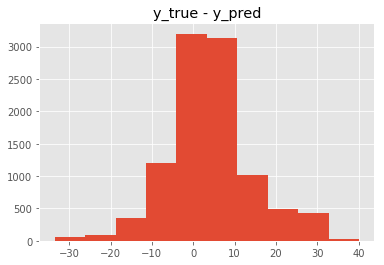

In [5]:
# Validate interpolation on many partitions
totcor = 0
y_pred_all = []
y_true_all = []
N = 1000
for k in range(N):
    tidx = [np.random.randint(0, len(df)) for i in range(10)]
    trows = [df.iloc[idx] for idx in tidx]
    df_train = df.drop(df.index[tidx])
    rbfi = gen_interpolator(df_train, ins, outs)
    
    y_pred = [float(rbfi(*[row[rep] for rep in ins])) for row in trows]
    y_true = [row[outs[0]] for row in trows]

    correct = []
    for i in range(len(y_pred)):
        correct.append((y_pred[i] > 0.5) == (y_true[i] > 0.5))
    totcor += sum(correct) / len(y_pred)
    y_pred_all.extend(y_pred)
    y_true_all.extend(correct)

# This represents the expected rate at which the interpolator correctly predicts the outcome of the race
print('Fraction of Races Predicted Correctly: ' + str(totcor / N))
print('Mean Squared Prediction Error: ' + str(mse(y_true_all, y_pred_all)))
print('Mean Absolute Prediction Error: ' + str(mae(y_true_all, y_pred_all)))
print('Stdev Prediction Error: ' + str(np.std(np.array(y_true_all) - np.array(y_pred_all))))

plt.hist(np.array(y_true_all) - np.array(y_pred_all))
plt.title('y_true - y_pred')
plt.show()

# Final Answer

We now plug in all available data to an interpolator and interpolate all rows. Keep in mind we expect our interpolation error to be drawn from the distribution shown above.

In [6]:
# TODO do it